Transcribing with both models:   0%|                                                            | 0/39 [00:00<?, ?it/s]`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavio

Comparison saved to comparisonBaseModelDatasetA_.csv

Baseline Whisper Avg Accuracy: 67.73%
Fine-Tuned Whisper Avg Accuracy: 74.56%


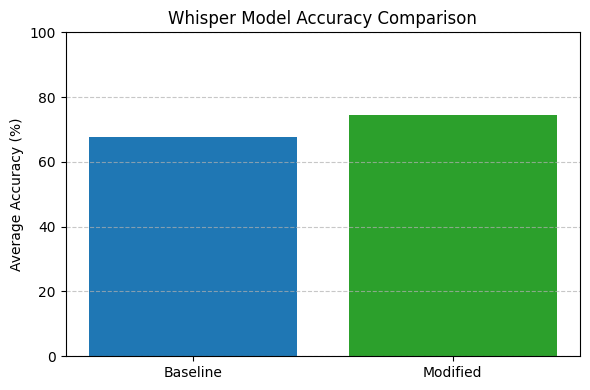

In [1]:
#comparing the whisper base model with finetune whisper base model on dataset a

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]            
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetA_.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/a/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetA_.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [08:40<00:00, 10.21s/it]


Comparison saved to comparisonBaseModelDatasetB_.csv

Baseline Whisper Avg Accuracy: 51.39%
Fine-Tuned Whisper Avg Accuracy: 64.43%


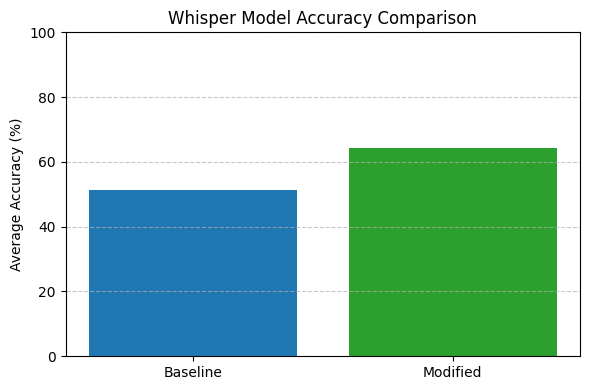

In [14]:
#comparing the whisper base model with finetune whisper base model on dataset b

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetB_.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/b/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetB_.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 32/32 [06:44<00:00, 12.64s/it]


Comparison saved to comparisonBaseModelDatasetC.csv

Baseline Whisper Avg Accuracy: 39.97%
Fine-Tuned Whisper Avg Accuracy: 62.59%


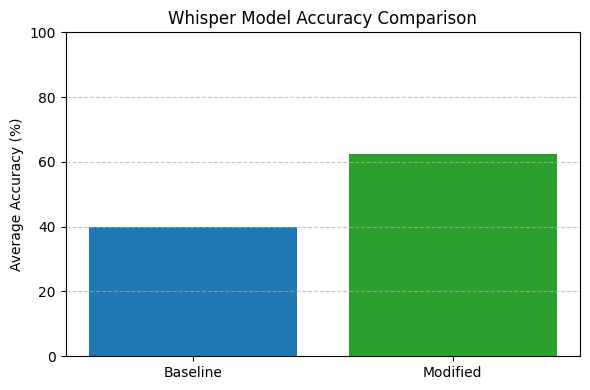

In [13]:
#comparing the whisper base model with finetune whisper base model on dataset c

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetC.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/c/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetC.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 66/66 [09:32<00:00,  8.68s/it]


Comparison saved to comparisonBaseModelDatasetD.csv

Baseline Whisper Avg Accuracy: 71.93%
Fine-Tuned Whisper Avg Accuracy: 78.56%


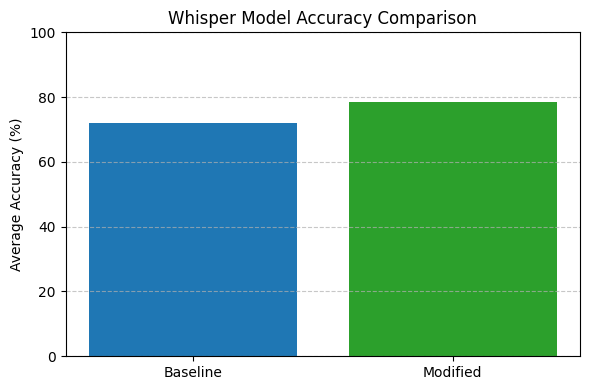

In [15]:
#comparing the whisper base model with finetune whisper base model on dataset d

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetD.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/d/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetD.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Transcribing with both models: 100%|███████████████████████████████████████████████████| 39/39 [05:08<00:00,  7.92s/it]


Comparison saved to comparisonBaseModelDatasetA_1.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 66.52%
Fine-Tuned Whisper Avg Accuracy: 74.56%


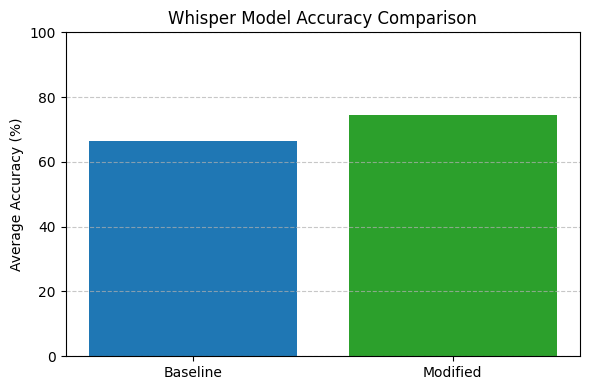

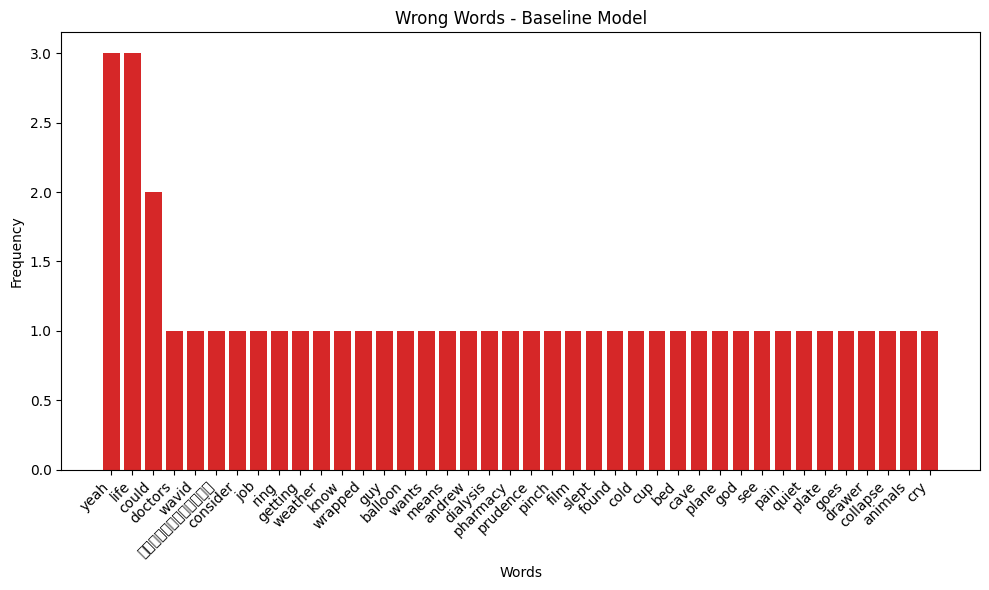

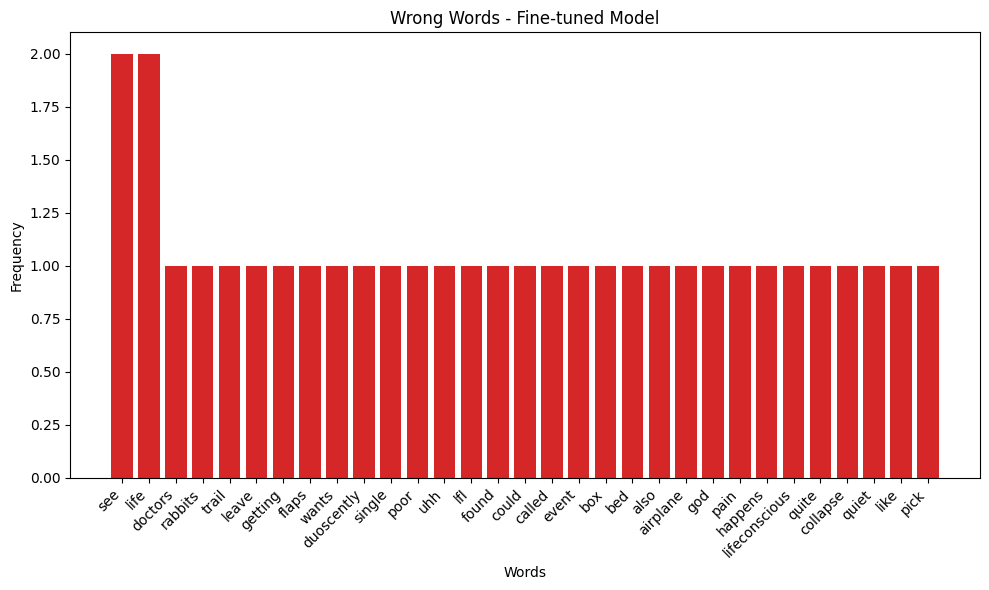

In [6]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])
    
stop_words = set(stopwords.words('english'))

supported_formats = (".mp3", ".wav")

# Load models
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def get_wrong_words(truth, hypothesis):
    """
    Align truth and hypothesis using difflib and return mismatched content words in hypothesis.
    """
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            # Only focus on content words
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100, 0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        # For wrong word distribution
        truth_words = transforms(ground_truth)[0]
        base_words = transforms(base_text)[0]
        mod_words = transforms(modified_text)[0]

        base_wrong = get_wrong_words(truth_words, base_words)
        mod_wrong = get_wrong_words(truth_words, mod_words)

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetA_1.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

# Run
audio_dir = "dataset/a/"  
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save comparison CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetA_1.csv")

# Save wrong word distribution
save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words.csv")
print("Wrong word distributions saved.")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Optional: plot top wrong words
def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common())
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotates labels for better readability
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words.png")


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [06:03<00:00,  7.13s/it]


Comparison saved to comparisonBaseModelDatasetB_1.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 52.45%
Fine-Tuned Whisper Avg Accuracy: 64.43%


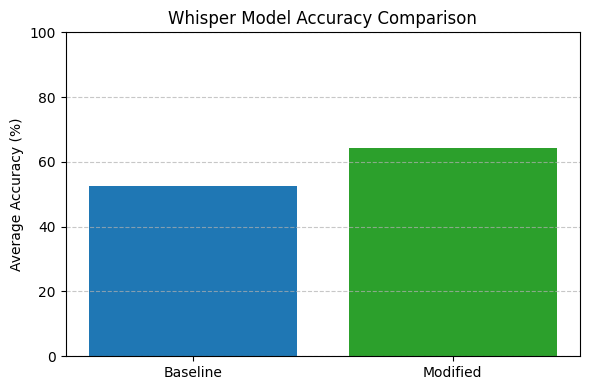

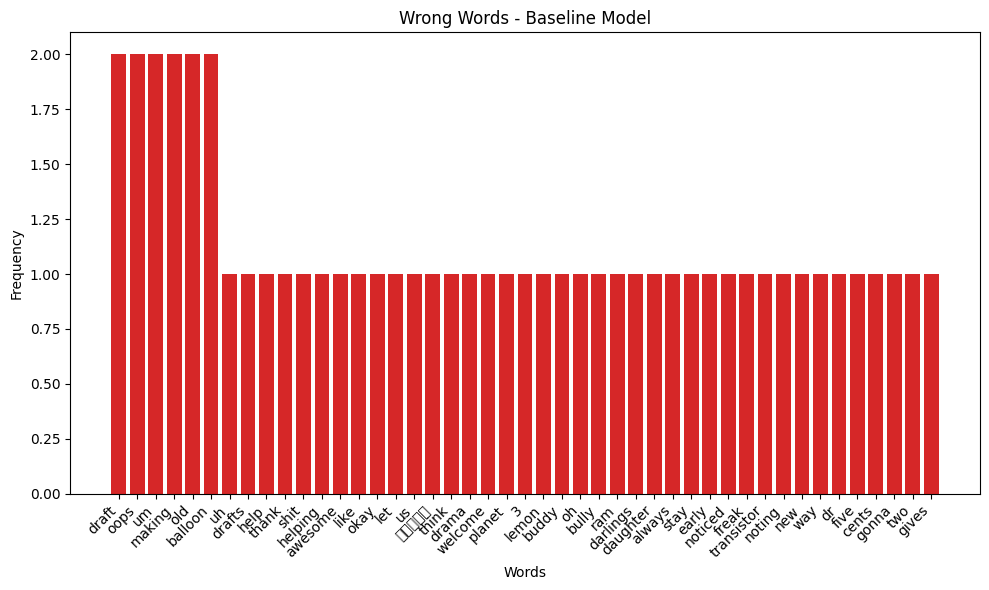

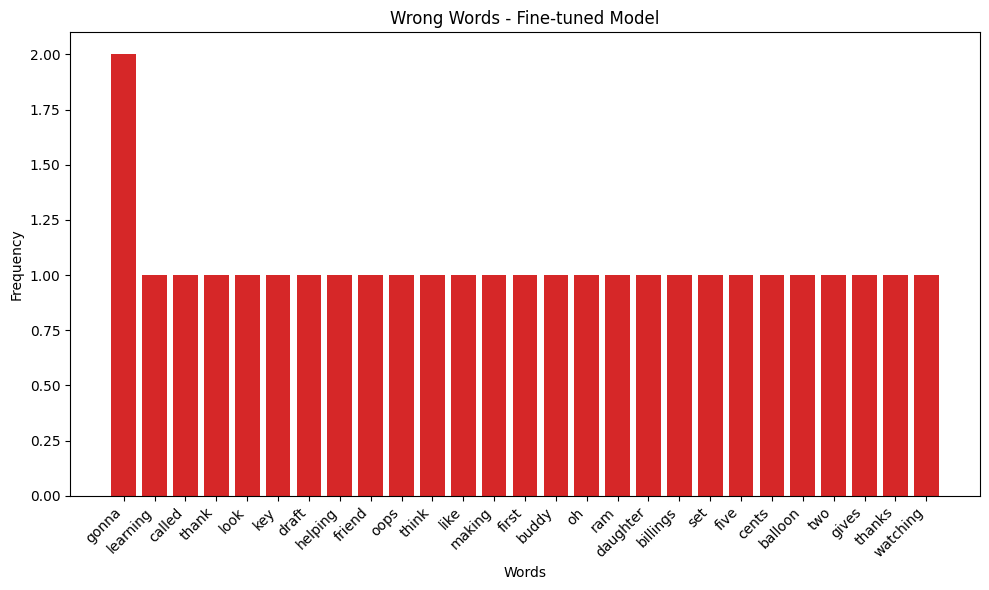

In [7]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))


supported_formats = (".mp3", ".wav")

# Load models
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def get_wrong_words(truth, hypothesis):
    """
    Align truth and hypothesis using difflib and return mismatched content words in hypothesis.
    """
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            # Only focus on content words
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100, 0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        # For wrong word distribution
        truth_words = transforms(ground_truth)[0]
        base_words = transforms(base_text)[0]
        mod_words = transforms(modified_text)[0]

        base_wrong = get_wrong_words(truth_words, base_words)
        mod_wrong = get_wrong_words(truth_words, mod_words)

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetB_1.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

# Run
audio_dir = "dataset/b/"  
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save comparison CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetB_1.csv")

# Save wrong word distribution
save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_b.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_b.csv")
print("Wrong word distributions saved.")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Optional: plot top wrong words
def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common())
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotates labels for better readability
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_b.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_b.png")


Transcribing with both models: 100%|███████████████████████████████████████████████████| 32/32 [04:25<00:00,  8.29s/it]


Comparison saved to comparisonBaseModelDatasetC_1.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 41.07%
Fine-Tuned Whisper Avg Accuracy: 62.59%


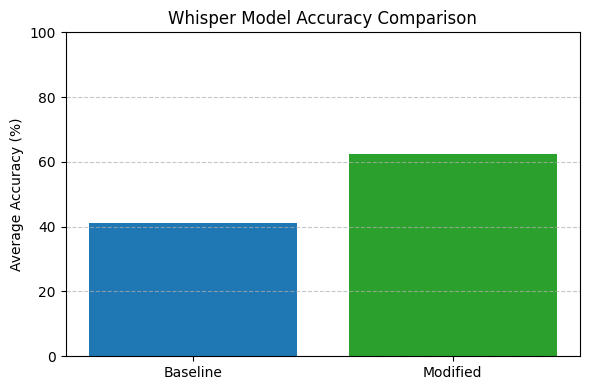

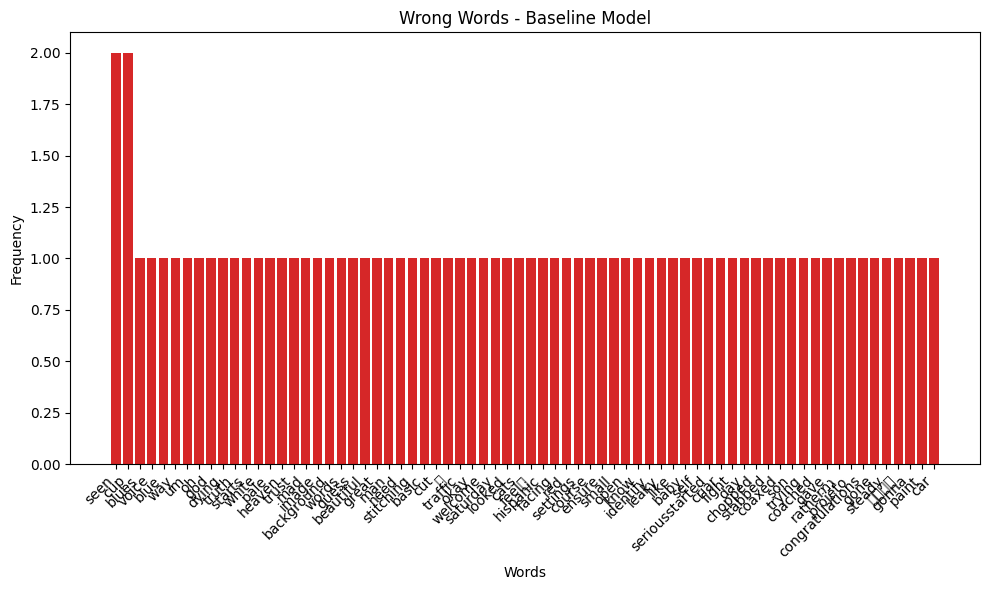

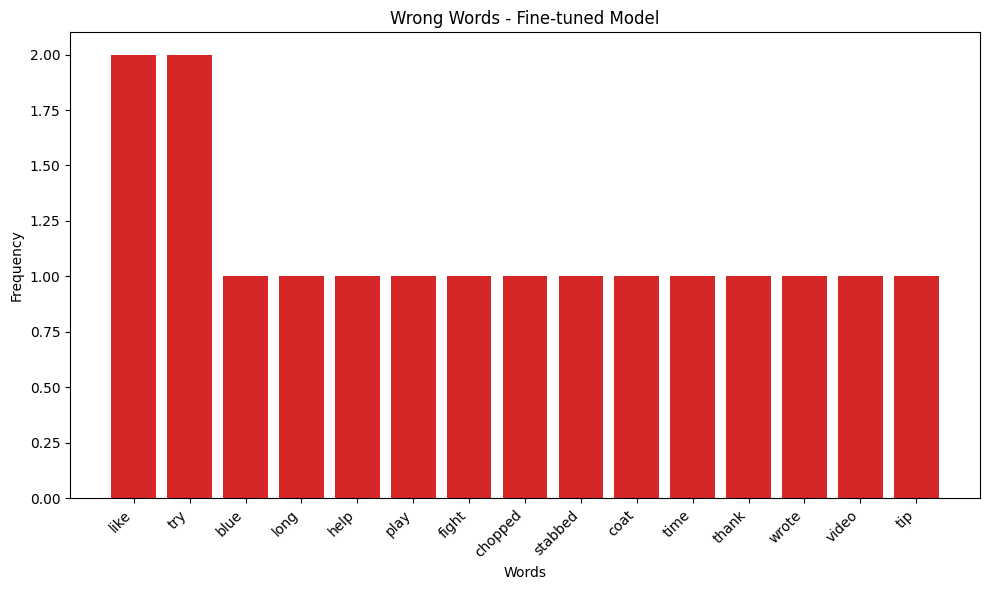

In [13]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import spacy

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

supported_formats = (".mp3", ".wav")

# Load models
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def get_wrong_words(truth, hypothesis):
    """
    Align truth and hypothesis using difflib and return mismatched content words in hypothesis.
    """
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            # Only focus on content words
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100, 0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        # For wrong word distribution
        truth_words = transforms(ground_truth)[0]
        base_words = transforms(base_text)[0]
        mod_words = transforms(modified_text)[0]

        base_wrong = get_wrong_words(truth_words, base_words)
        mod_wrong = get_wrong_words(truth_words, mod_words)

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetC_1.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

# Run
audio_dir = "dataset/c/"  
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save comparison CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetC_1.csv")

# Save wrong word distribution
save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_c.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_c.csv")
print("Wrong word distributions saved.")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common())
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotates labels for better readability
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_c.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_c.png")


Transcribing with both models: 100%|███████████████████████████████████████████████████| 66/66 [06:47<00:00,  6.18s/it]


Comparison saved to comparisonBaseModelDatasetD_1.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 71.49%
Fine-Tuned Whisper Avg Accuracy: 78.56%


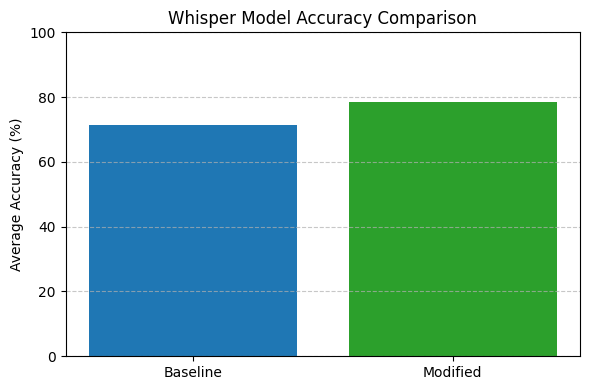

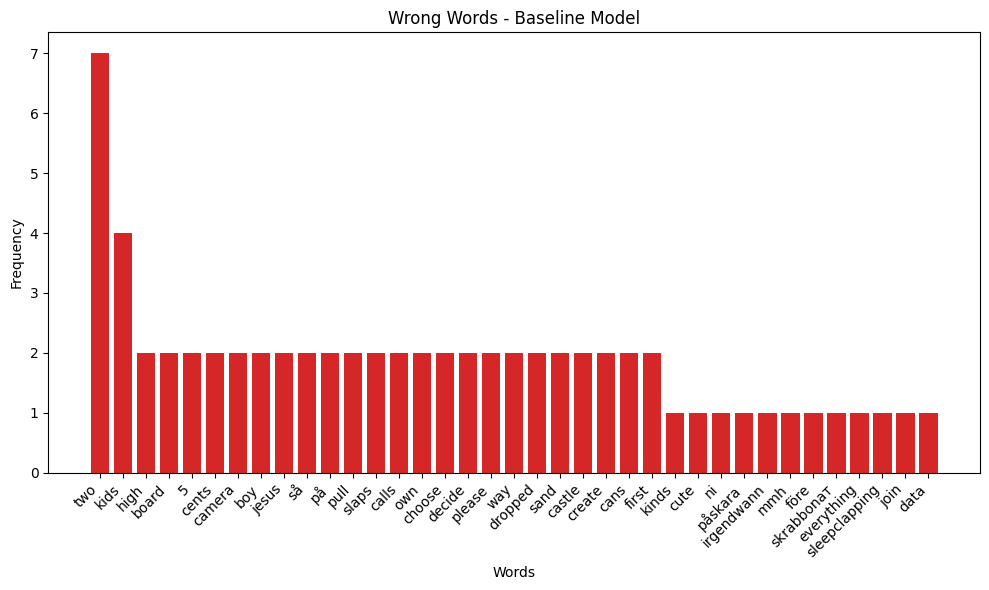

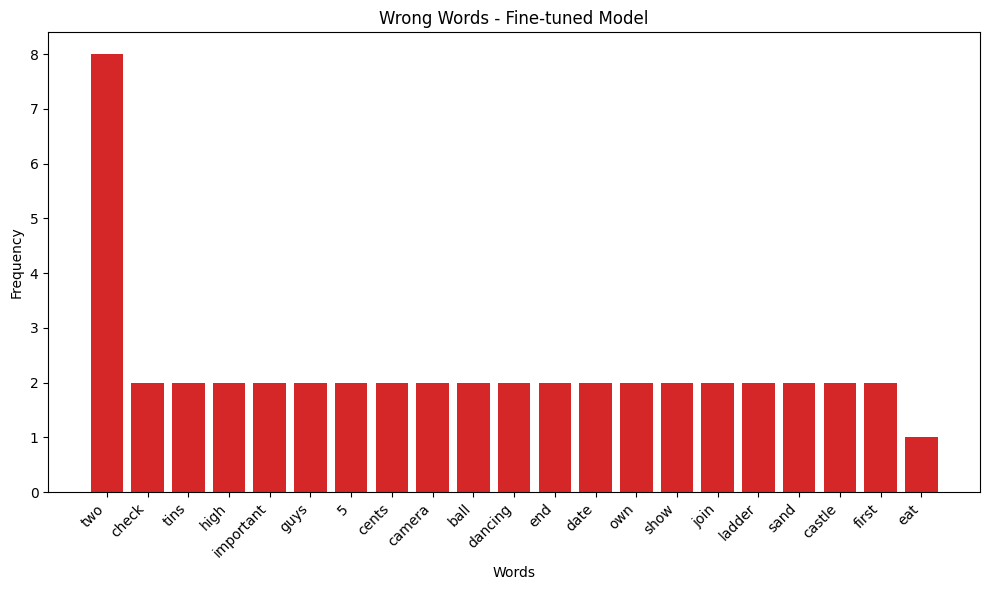

In [14]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set([
    # Articles
    "a", "an", "the",

    # Pronouns
    "i", "you", "he", "she", "it", "we", "they",
    "me", "him", "her", "us", "them",
    "my", "your", "his", "her", "its", "our", "their",
    "mine", "yours", "hers", "ours", "theirs",

    # Auxiliary / Modal / Common Verbs
    "is", "am", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having",
    "do", "does", "did", "doing",
    "can", "could", "will", "would", "shall", "should", "may", "might", "must",
    "get", "gets", "got", "getting",
    "let", "lets", "need", "needs", "want", "wants", "wanted", "make", "makes", "made",
    "go", "goes", "went", "gone", "come", "comes", "came",
    "use", "uses", "used",
    "know", "knows", "knew", "think", "thinks", "thought",
    "see", "saw", "seen", "watch", "watches", "watched", "watching",
    "say", "says", "said", "talk", "talks", "talked", "talking",
    "take", "takes", "took", "give", "gives", "gave",
    "keep", "keeps", "kept", "put", "puts", "putting",
    "like", "likes", "liked", "liking",
    "feel", "feels", "felt", "feeling",
    "look", "looks", "looked", "looking",
    "hear", "hears", "heard", "hearing",
    "leave", "leaves", "left",
    "stay", "stays", "stayed",
    "seem", "seems", "seemed",
    "appear", "appears", "appeared",

    # Informal / contractions
    "gonna", "wanna", "gotta", "ain't", "lemme", "gimme", "tryna", "outta", "lotta",
    "y'all", "yo", "dunno", "nah", "yeah", "yup", "nope",

    # Locations / Pointers
    "here", "there", "this", "that", "these", "those", "where", "somewhere", "anywhere", "nowhere",

    # Prepositions
    "in", "on", "at", "by", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down", "over", "under",
    "out", "off", "onto", "upon", "beside", "beyond", "within", "without", "around", "across",
    "behind", "near", "toward", "underneath", "among", "amid", "beneath", "outside", "inside",
    "for", "of", "since", "until",

    # Conjunctions
    "and", "or", "but", "nor", "so", "yet",
    "although", "though", "because", "since", "if", "unless", "until", "while",
    "when", "whenever", "where", "wherever", "as", "than", "then", "once", "that",
    "whether", "even though", "whereas", "while", "whilst",
    "for", "as if", "as long as", "as soon as", "in order that", "so that",

    # Determiners / Quantifiers / Demonstratives
    "each", "every", "all", "some", "any", "both", "either", "neither",
    "few", "little", "much", "many", "more", "most", "several", "such",
    "this", "that", "these", "those", "other", "another",

    # Adverbs / Intensifiers / Connectors
    "very", "too", "also", "just", "even", "still", "again", "really", "quite", "almost",
    "already", "soon", "often", "sometimes", "frequently", "usually", "generally", "typically",
    "however", "nevertheless", "furthermore", "moreover", "consequently", "therefore",
    "hence", "thus", "accordingly", "instead", "otherwise", "likewise", "similarly",
    "anyway", "meanwhile", "besides", "regardless",

    # Discourse / Fillers
    "well", "ok", "okay", "yeah", "yes", "no", "uh", "um", "hmm", "huh", "alright",
    "hey", "uhh", "oh", "oops", "uh-oh", "yikes", "huh", "hurray",

    # Negations / Affirmatives
    "not", "never", "ever", "indeed", "absolutely", "nope", "nah", "yes", "sure", "definitely",

    # Interrogatives / Relative Pronouns
    "what", "who", "whom", "whose", "which", "how", "why", "where", "when",
    "that", "whosever", "whichever", "whatever", "whenever", "wherever", "however"
])

supported_formats = (".mp3", ".wav")

# Load models
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def get_wrong_words(truth, hypothesis):
    """
    Align truth and hypothesis using difflib and return mismatched content words in hypothesis.
    """
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            # Only focus on content words
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100, 0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        # For wrong word distribution
        truth_words = transforms(ground_truth)[0]
        base_words = transforms(base_text)[0]
        mod_words = transforms(modified_text)[0]

        base_wrong = get_wrong_words(truth_words, base_words)
        mod_wrong = get_wrong_words(truth_words, mod_words)

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetD_1.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

# Run
audio_dir = "dataset/d/"  
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save comparison CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetD_1.csv")

# Save wrong word distribution
save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_d.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_d.csv")
print("Wrong word distributions saved.")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Optional: plot top wrong words
def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common())
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotates labels for better readability
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_d.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_d.png")
